# Models training

## Import dependencies

In [288]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', True)

## Load data

### Load the historical generation and weather training data that was augmented using feature engineering in the previous notebook

In [289]:
GEN_DATA_PATH = os.path.join('..', 'data', '2_feature_engineered_data.parquet')
df = pd.read_parquet(GEN_DATA_PATH)
TARGET_COL = 'DC Gen. Power'
display(df.head(5))

,Temperature,Precipitation Total,Relative Humidity,Wind Speed,Wind Direction,Cloud Cover Total,Cloud Cover High,Cloud Cover Medium,Cloud Cover Low,CAPE,Sunshine Duration,Shortwave Radiation,Longwave Radiation,UV Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Mean Sea Level Pressure,DC Gen. Power,Device Temp.,Voltage,day,season_0,season_1,season_2,season_3,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,DC Gen. Power 1 Hour Lag,DC Gen. Power 2 Hour Lag,DC Gen. Power 4 Hour Lag,DC Gen. Power 24 Hour Lag,DC Gen. Power 720 Hour Lag,DC Gen. Power 24 Hour Rolling Mean,DC Gen. Power 24 Hour Rolling Std,DC Gen. Power 24 Hour Rolling Max,DC Gen. Power 24 Hour Rolling EMA,Shortwave Radiation 24 Hour Rolling Mean,Shortwave Radiation 24 Hour Rolling Std,Shortwave Radiation 24 Hour Rolling Max,Shortwave Radiation 24 Hour Rolling EMA,Wind Speed 24 Hour Rolling Mean,Wind Speed 24 Hour Rolling Std,Wind Speed 24 Hour Rolling Max,Wind Speed 24 Hour Rolling EMA,Temperature 24 Hour Rolling Mean,Temperature 24 Hour Rolling Std,Temperature 24 Hour Rolling Max,Temperature 24 Hour Rolling EMA,Relative Humidity 24 Hour Rolling Mean,Relative Humidity 24 Hour Rolling Std,Relative Humidity 24 Hour Rolling Max,Relative Humidity 24 Hour Rolling EMA,DC Gen. Power 48 Hour Rolling Mean,DC Gen. Power 48 Hour Rolling Std,DC Gen. Power 48 Hour Rolling Max,DC Gen. Power 48 Hour Rolling EMA,Shortwave Radiation 48 Hour Rolling Mean,Shortwave Radiation 48 Hour Rolling Std,Shortwave Radiation 48 Hour Rolling Max,Shortwave Radiation 48 Hour Rolling EMA,Wind Speed 48 Hour Rolling Mean,Wind Speed 48 Hour Rolling Std,Wind Speed 48 Hour Rolling Max,Wind Speed 48 Hour Rolling EMA,Temperature 48 Hour Rolling Mean,Temperature 48 Hour Rolling Std,Temperature 48 Hour Rolling Max,Temperature 48 Hour Rolling EMA,Relative Humidity 48 Hour Rolling Mean,Relative Humidity 48 Hour Rolling Std,Relative Humidity 48 Hour Rolling Max,Relative Humidity 48 Hour Rolling EMA,DC Gen. Power 720 Hour Rolling Mean,DC Gen. Power 720 Hour Rolling Std,DC Gen. Power 720 Hour Rolling Max,DC Gen. Power 720 Hour Rolling EMA,Shortwave Radiation 720 Hour Rolling Mean,Shortwave Radiation 720 Hour Rolling Std,Shortwave Radiation 720 Hour Rolling Max,Shortwave Radiation 720 Hour Rolling EMA,Wind Speed 720 Hour Rolling Mean,Wind Speed 720 Hour Rolling Std,Wind Speed 720 Hour Rolling Max,Wind Speed 720 Hour Rolling EMA,Temperature 720 Hour Rolling Mean,Temperature 720 Hour Rolling Std,Temperature 720 Hour Rolling Max,Temperature 720 Hour Rolling EMA,Relative Humidity 720 Hour Rolling Mean,Relative Humidity 720 Hour Rolling Std,Relative Humidity 720 Hour Rolling Max,Relative Humidity 720 Hour Rolling EMA,Hours Since Last Rain,days_since_installation,Wind Chill,Solar Zenith Angle
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31 00:00:00,16.0,0.0,88.0,17.0,129.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,306.0,0.0,0.0,0.0,1020.0,0.0,0.0,0.0,31,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,6744.3,0.0,0.0,20702.048333,25422.499537,97134.2,22580.746457,137.791667,155.403816,436.0,136.488561,20.291667,4.328662,29.0,19.594985,16.666667,1.372610,19.0,16.704813,85.250000,5.581413,93.0,85.194185,28375.581458,39447.876913,132528.9,26008.695220,195.5,253.310591,868.0,165.523663,18.979167,3.569907,29.0,18.375800,16.541667,1.254071,19.0,17.064213,85.895833,5.802566,95.0,85.230450,22863.312833,47533.519316,204958.74,31273.318772,192.315278,280.372312,988.0,208.828267,16.459722,7.000778,33.0,15.785800,1

## Split data

The dataset is split into three subsets: training, validation, and testing. 

- The training set comprises 60% of the data, used to train the machine learning models and tune their parameters.
- The validation set, which constitutes 20% of the data, serves as an additional evaluation step during model training to assess performance and adjust hyperparameters.
- Finally, the testing set, also representing 20% of the data, remains untouched during model development and is solely used for final performance evaluation to gauge the model's generalization capability.


In [290]:
train, validate, test = np.split(df, [int(.6*len(df)), int(.8*len(df))])

x_train = train.drop(columns=[TARGET_COL])
x_val = validate.drop(columns=[TARGET_COL])
x_test = test.drop(columns=[TARGET_COL])

y_train = train[TARGET_COL]
y_val = validate[TARGET_COL]
y_test = test[TARGET_COL]

print('Train: ', len(train))
print('Validate: ', len(validate))
print('Test: ', len(test))

Train:  15152
Validate:  5051
Test:  5051


# Training

In this section, we delve into the technical aspects of machine learning model development and training. 

In [291]:
results = pd.DataFrame()
def calculate_metrics(y_pred, y_val, model_name, hyperparams):
    """
    Calculate metrics for the model
    """
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    global results
    df = pd.DataFrame({
        'model': [model_name],        
        'mae': [mae],
        'mse': [mse],
        'mae': [mae],
        'hyperparams': [hyperparams]
    })
    results = pd.concat([results, df])   

    return mse, rmse, mae

def plot_predictions(y_pred, y_val, n=200):
    """
    Plot predictions
    """
    plt.figure(figsize=(20, 8))
    plt.plot(y_val[-n:], label='Actual')
    plt.plot(y_pred[-n:], label='Predicted')
    plt.legend()
    plt.show()

def plot_feature_importance(model, x_val, y_val, n=20):
    r = permutation_importance(model, x_val, y_val, n_repeats=30, random_state=0)
    sorted_idx = r.importances_mean.argsort()[-n:]
    fig, ax = plt.subplots()
    ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=x_val.columns[sorted_idx])
    ax.set_title("Feature importance")
    fig.tight_layout()
    plt.show()

## Naive model
The Naive Model, which predicts the same value as the last observed hour, serves as a fundamental baseline for evaluating predictive performance against more complex algorithms.

MSE: 503191369.415721
RMSE: 22431.927456545527
MAE: 13297.458055830532


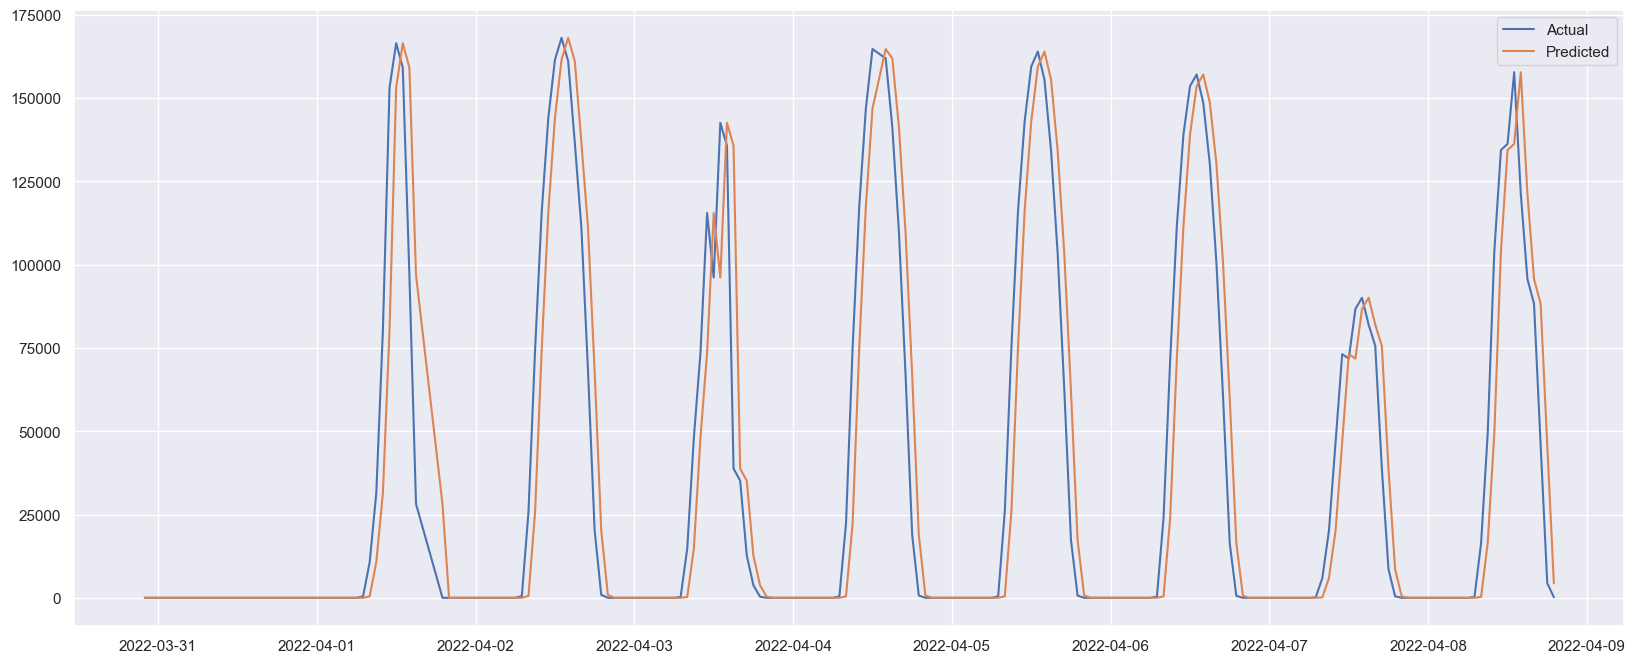

In [292]:
x_train = train.drop(columns=[TARGET_COL])
y_train = train[TARGET_COL]

y_pred = y_val.shift(1).fillna(method='bfill')

calculate_metrics(y_pred, y_val, 'Naive', {})
plot_predictions(y_pred, y_val)


## Linear models

Linear models serve as an essential starting point in predictive modeling and statistical analysis due to their simplicity, interpretability, and effectiveness in capturing linear relationships between variables.

### Linear regression

Linear regression, a core component of linear modeling, provides valuable insights into the relationship between independent variables and a continuous target variable. By assuming a linear relationship, linear models offer transparency in understanding how changes in predictors influence the outcome, making them accessible and interpretable for practitioners and stakeholders.

MSE: 130519056.23085883
RMSE: 11424.493696915362
MAE: 7925.8760167734645


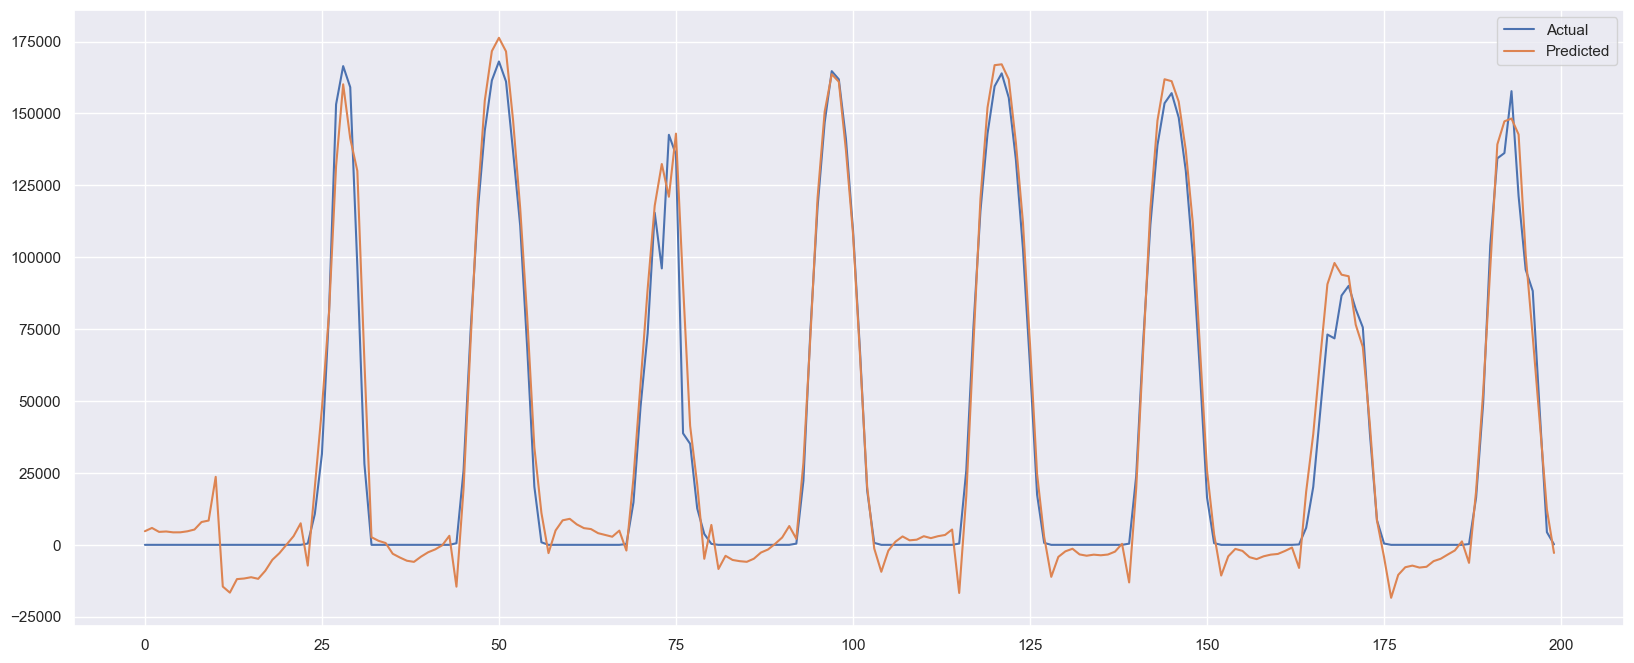

In [293]:

linear_regressor = LinearRegression()
model = make_pipeline(StandardScaler(), linear_regressor)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

calculate_metrics(y_pred, y_val, 'LinearRegression', linear_regressor.get_params(True))
plot_predictions(y_pred, y_val.values)


### Lasso

The Lasso Regression model, also known as L1 regularization, is a variant of linear regression that incorporates penalty terms to enforce sparsity in the coefficient estimates. By penalizing the absolute size of the coefficients, Lasso Regression encourages feature selection and promotes models with fewer predictors, making it particularly useful for high-dimensional datasets.

MSE: 134203367.40653808
RMSE: 11584.61770653387
MAE: 7704.290913110643


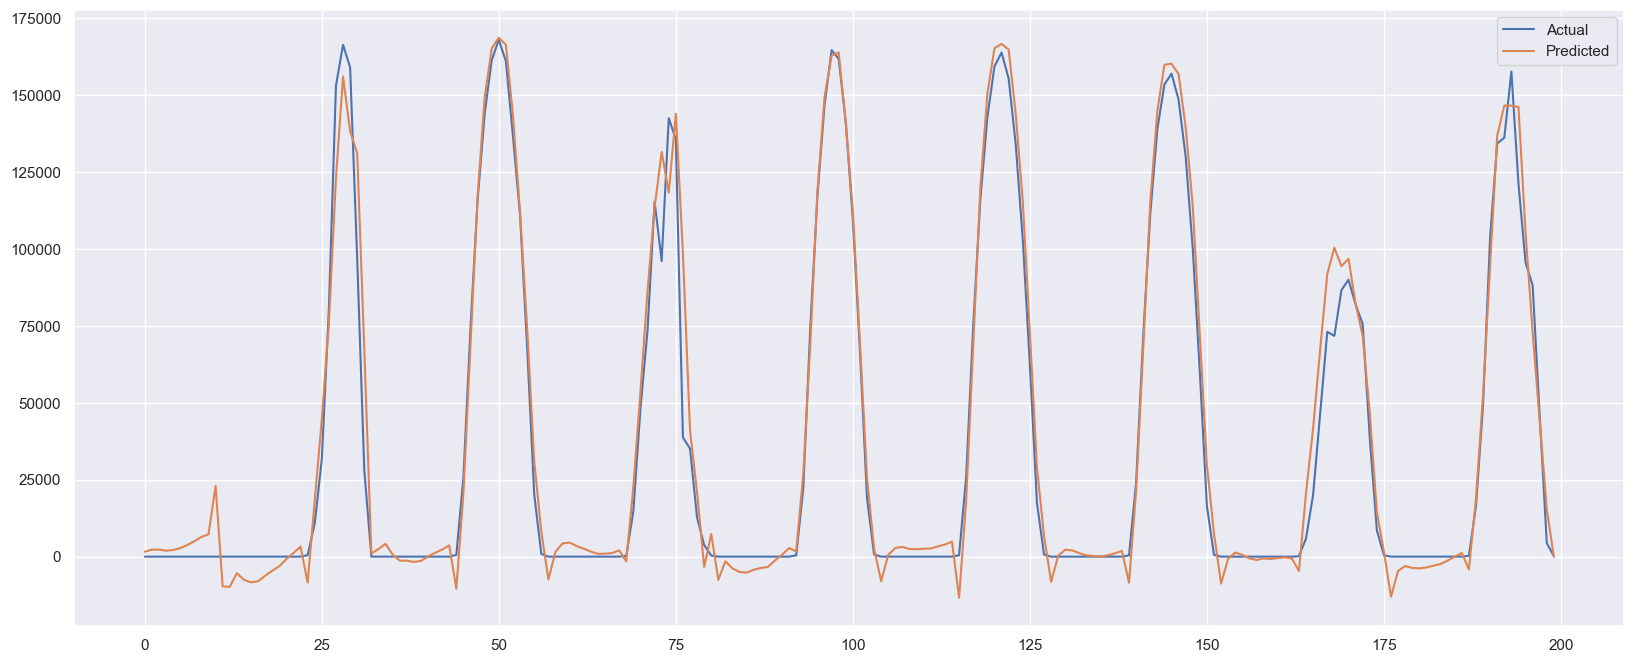

In [294]:

lasso = LassoCV()
model = make_pipeline(StandardScaler(), lasso)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

calculate_metrics(y_pred, y_val, 'LassoCV', lasso.get_params(True))
plot_predictions(y_pred, y_val.values)

### Ridge

Ridge Regression, a variant of linear regression, introduces L2 regularization to penalize the sum of squared coefficients, effectively shrinking their magnitudes. By imposing a penalty on large coefficients, Ridge Regression mitigates multicollinearity and reduces model complexity, promoting better generalization performance.


MSE: 130504514.31299147
RMSE: 11423.857243199052
MAE: 7901.131178148961


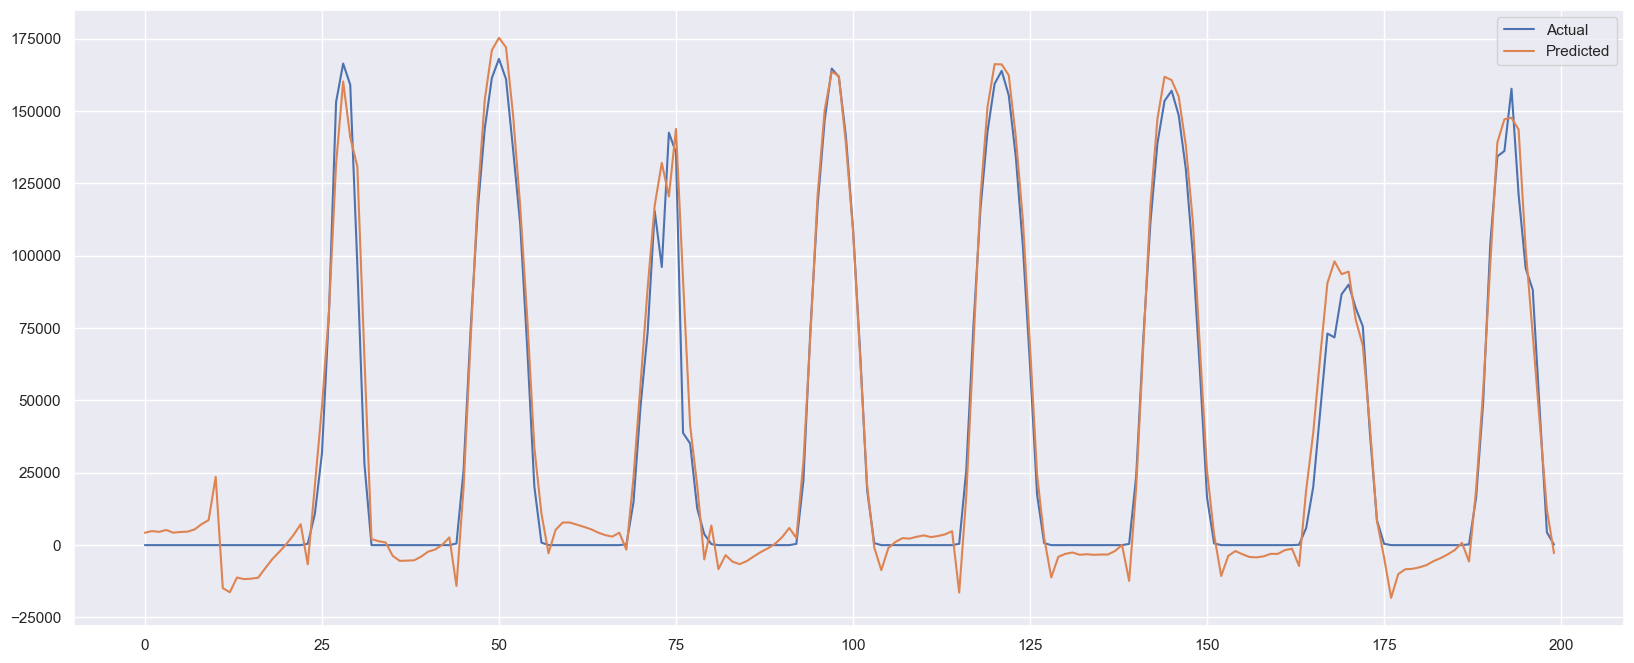

In [295]:
ridge = RidgeCV()
model = make_pipeline(StandardScaler(), ridge)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

calculate_metrics(y_pred, y_val, 'RidgeCV', ridge.get_params(True))
plot_predictions(y_pred, y_val.values)

### ElasticNet

ElasticNet Regression is a linear model that combines the regularization techniques of Ridge and Lasso regression. By incorporating both L1 (Lasso) and L2 (Ridge) penalties into its objective function, ElasticNet offers a balanced approach to feature selection and regularization. This hybrid model is particularly effective in scenarios with high-dimensional data and multicollinearity issues, providing a flexible framework for predictive modeling tasks. 


MSE: 214337153.31705254
RMSE: 14640.257966205805
MAE: 9405.670026568636


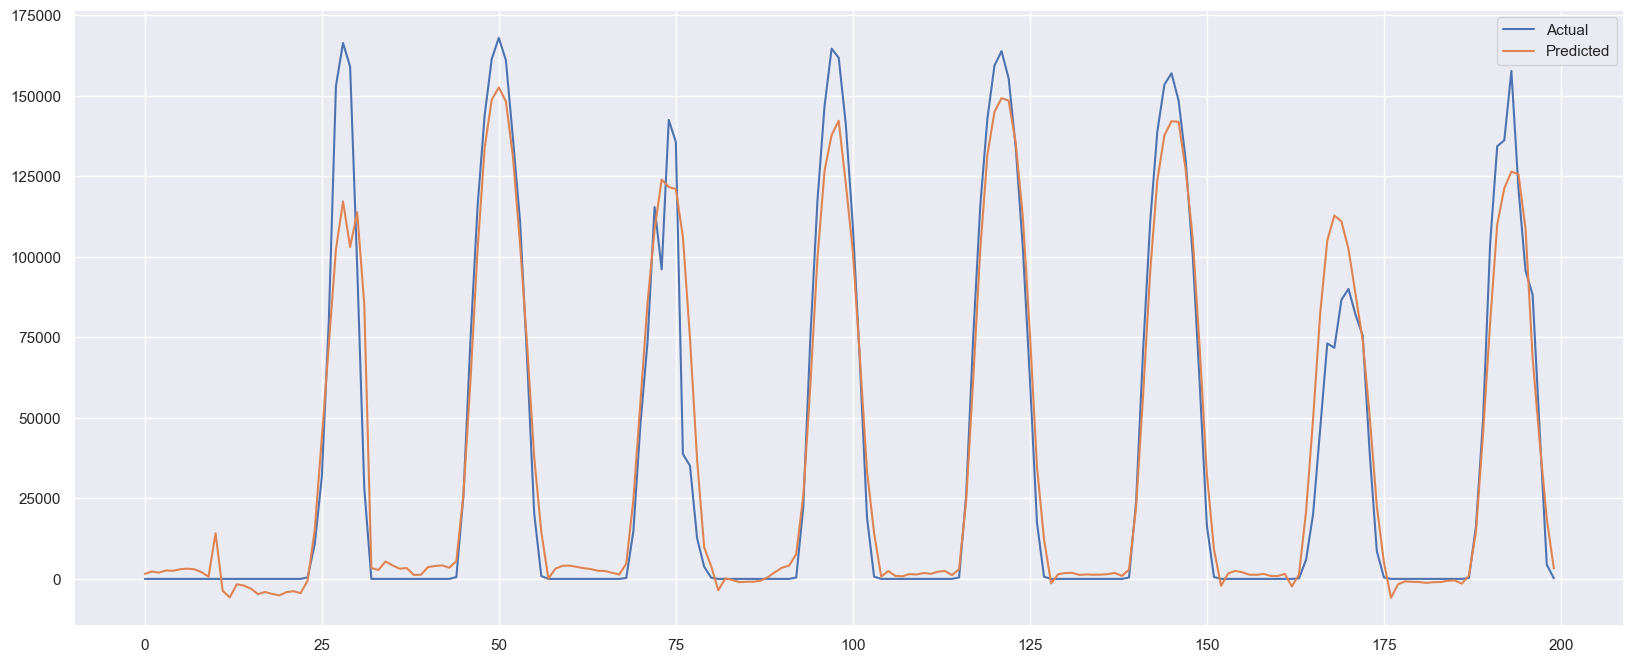

In [296]:
elastic_net = ElasticNet()
model = make_pipeline(StandardScaler(), elastic_net)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

calculate_metrics(y_pred, y_val, 'ElasticNet', elastic_net.get_params(True))
plot_predictions(y_pred, y_val.values)

In [297]:
results.sort_values(by='mae', ascending=True)


,model,mae,mse,hyperparams
0,LassoCV,7704.290913,1.342034e+08,"{'alphas': None, 'copy_X': True, 'cv': None, '..."
0,RidgeCV,7901.131178,1.305045e+08,"{'alpha_per_target': False, 'alphas': (0.1, 1...."
0,LinearRegression,7925.876017,1.305191e+08,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
0,ElasticNet,9405.670027,2.143372e+08,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
0,Naive,13297.458056,5.031914e+08,{}
